In [280]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Function to evaluate logistic regression model for a sensitive attribute
def evaluate_sensitive_attribute(df, sensitive_attribute, group_name_str):
    # Separate features (X) and target (y)
    X = df.drop(['target'], axis=1)  # Drop the target column
    y = df['target']  # Assuming 'target' is your target column
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Handle missing values if any
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Standardize numerical features if necessary
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train a logistic regression model
    model = LogisticRegression(max_iter=200, class_weight='balanced', solver='liblinear')
    model.fit(X_train, y_train)
    
    # Evaluate on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and confusion matrix
    accuracy = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    # Print results for the current sensitive attribute
    print(f"\nEvaluation for {sensitive_attribute} - Group: {group_name_str}")
    print(f"Accuracy: {accuracy}")
    print(f"Sensitivity (True Positive Rate): {sensitivity}")
    print(f"Specificity (True Negative Rate): {specificity}")
    
    # Print classification report for more detailed metrics
    print(f"\nClassification Report for {sensitive_attribute} - Group: {group_name_str}")
    print(classification_report(y_test, y_pred))
    
    # Store results in a structured format
    results = {
        'Attribute': sensitive_attribute,
        'Group': group_name_str,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity
    }
    
    return results


In [281]:
# Load your dataset (processed_data.csv assumed to be loaded)
df = pd.read_csv('data/processed_data.csv')

# Map column names to readable group names
race1_map = {
    'race1_asian': 'Asian',
    'race1_black': 'Black',
    'race1_hisp': 'Hisp',
    'race1_other': 'Other',
    'race1_white': 'White'
}

gender_map = {
    1: 'Male',
    0: 'Female'
}

# Group data by sensitive attribute and evaluate for each group
sensitive_attributes = ['race1', 'gender']
results = []

for sensitive_attribute in sensitive_attributes:
    print(f"\nSensitive Attribute: {sensitive_attribute}")
    
    # Evaluate logistic regression model for each subgroup
    if sensitive_attribute == 'race1':
        # For race1, iterate over each race category
        for col in ['race1_asian', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white']:
            group_name_str = race1_map[col]
            group_df = df[df[col] == 1.0]  # Filter rows where the race1 category is 1.0 (True)
            subgroup_results = evaluate_sensitive_attribute(group_df, sensitive_attribute, group_name_str)
            results.append(subgroup_results)
    else:
        # For gender, iterate over each gender category
        for group_name, group_name_str in gender_map.items():
            group_df = df[df['gender'] == group_name]  # Filter rows where gender matches the current category
            subgroup_results = evaluate_sensitive_attribute(group_df, sensitive_attribute, group_name_str)
            results.append(subgroup_results)

# Display results for each subgroup within each sensitive attribute
print("\nSummary of Results:")
for result in results:
    print(result)



Sensitive Attribute: race1

Evaluation for race1 - Group: Asian
Accuracy: 0.7333333333333333
Sensitivity (True Positive Rate): 0.7453416149068323
Specificity (True Negative Rate): 0.631578947368421

Classification Report for race1 - Group: Asian
              precision    recall  f1-score   support

           0       0.23      0.63      0.33        19
           1       0.94      0.75      0.83       161

    accuracy                           0.73       180
   macro avg       0.59      0.69      0.58       180
weighted avg       0.87      0.73      0.78       180


Evaluation for race1 - Group: Black
Accuracy: 0.6691449814126395
Sensitivity (True Positive Rate): 0.6439024390243903
Specificity (True Negative Rate): 0.75

Classification Report for race1 - Group: Black
              precision    recall  f1-score   support

           0       0.40      0.75      0.52        64
           1       0.89      0.64      0.75       205

    accuracy                           0.67       269
  

/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_82890/1595281560.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Race Subgroup', y='Accuracy', data=race_accuracy_df, palette="viridis", ax=ax1)
/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_82890/1595281560.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
/var/folders/kk/cjvhrlcd2d3b4mbcr9q9bh900000gp/T/ipykernel_82890/1595281560.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gender Subgroup', y='Accuracy', data=gender_accuracy_df, palette="viridis", ax=ax2)
/

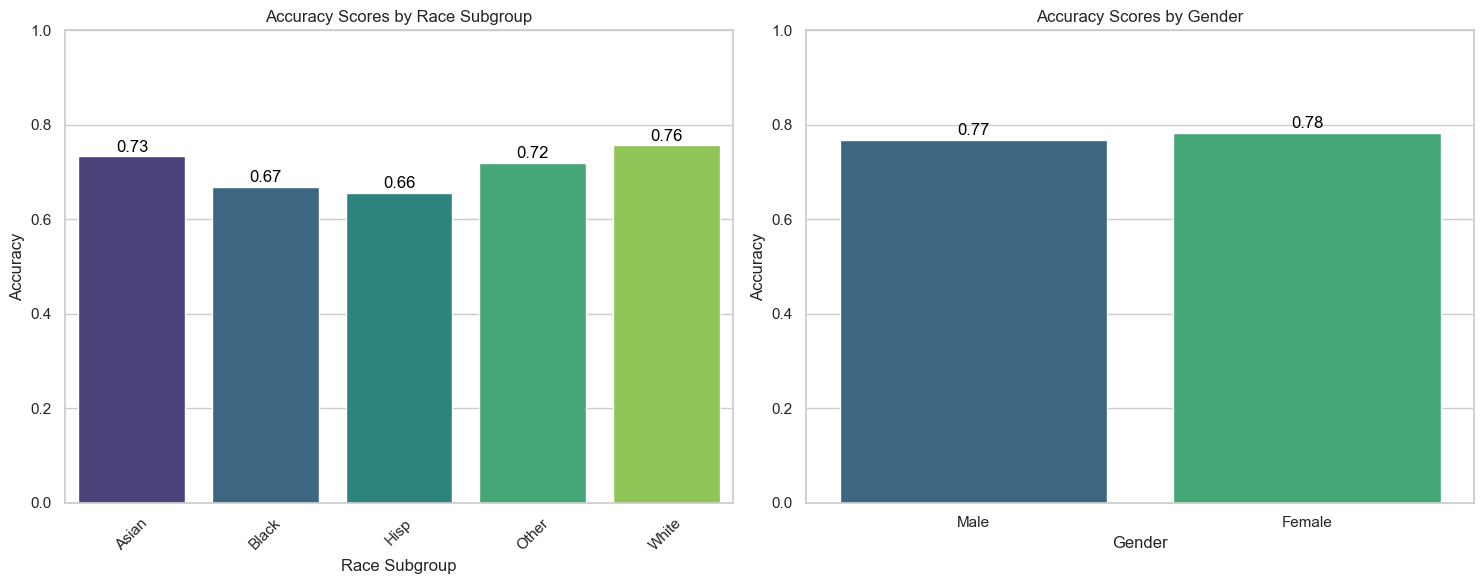

In [282]:
# Extract accuracy scores for each race subgroup
race_subgroups = [result['Group'] for result in results if result['Attribute'] == 'race1']
race_accuracy_scores = [result['Accuracy'] for result in results if result['Attribute'] == 'race1']

# Extract accuracy scores for each gender subgroup
gender_subgroups = [result['Group'] for result in results if result['Attribute'] == 'gender']
gender_accuracy_scores = [result['Accuracy'] for result in results if result['Attribute'] == 'gender']

# Create a DataFrame for plotting race accuracy
race_accuracy_df = pd.DataFrame({'Race Subgroup': race_subgroups, 'Accuracy': race_accuracy_scores})

# Create a DataFrame for plotting gender accuracy
gender_accuracy_df = pd.DataFrame({'Gender Subgroup': gender_subgroups, 'Accuracy': gender_accuracy_scores})

# Set plot style
sns.set(style="whitegrid")

# Create figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))

# Plot for race accuracy scores
sns.barplot(x='Race Subgroup', y='Accuracy', data=race_accuracy_df, palette="viridis", ax=ax1)
ax1.set_title('Accuracy Scores by Race Subgroup')
ax1.set_xlabel('Race Subgroup')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)  # Set y-axis limit from 0 to 1
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Annotate race accuracy scores on bars
for index, row in race_accuracy_df.iterrows():
    ax1.text(index, row['Accuracy'] + 0.01, f'{row["Accuracy"]:.2f}', color='black', ha="center")

# Plot for gender accuracy scores
sns.barplot(x='Gender Subgroup', y='Accuracy', data=gender_accuracy_df, palette="viridis", ax=ax2)
ax2.set_title('Accuracy Scores by Gender')
ax2.set_xlabel('Gender')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)  # Set y-axis limit from 0 to 1
ax2.set_xticklabels(ax2.get_xticklabels())

# Annotate gender accuracy scores on bars
for index, row in gender_accuracy_df.iterrows():
    ax2.text(index, row['Accuracy'] + 0.01, f'{row["Accuracy"]:.2f}', color='black', ha="center")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [283]:
df = pd.read_csv('processed_data.csv')



In [284]:
from sklearn.model_selection import train_test_split

def preprocess_and_split_data(df):
    # Define features and target
    features = df.drop('target', axis=1)  # Drop the target column to get features
    target = df['target']

    # Define groups (race and gender)
    groups = df[['race1_asian', 'race1_black', 'race1_hisp', 'race1_other', 'gender']]

    # Drop unnecessary columns from features
    features.drop(['race1_asian', 'race1_black', 'race1_hisp', 'race1_other', 'gender'], axis=1, inplace=True)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        features, target, groups, test_size=0.3, random_state=0, shuffle=True
    )

        
    # Handle missing values if any
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    
    # Standardize numerical features if necessary
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    

    return X_train, X_test, y_train, y_test, group_train, group_test

# Preprocess and split data
X_train, X_test, y_train, y_test, group_train, group_test = preprocess_and_split_data(df)

# Printing the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("group_train shape:", group_train.shape)
print("group_test shape:", group_test.shape)


X_train shape: (15684, 11)
X_test shape: (6723, 11)
y_train shape: (15684,)
y_test shape: (6723,)
group_train shape: (15684, 5)
group_test shape: (6723, 5)


In [285]:
group_train.head()

,race1_asian,race1_black,race1_hisp,race1_other,gender
3140,1.0,0.0,0.0,0.0,0.0
17429,0.0,0.0,0.0,0.0,1.0
13966,0.0,0.0,0.0,0.0,1.0
17362,0.0,0.0,0.0,0.0,1.0
21466,0.0,0.0,0.0,0.0,0.0


In [290]:
from sklearn.decomposition import PCA as SklearnPCA
from scipy.linalg import null_space
import matplotlib.pyplot as plt
import numpy as np


def PCA(X_train, n_components):
    """ Implements sci-kit's version of basic PCA and returns sorted eigenvectors"""
    
    pca = SklearnPCA(n_components=n_components)
    X_PCA = pca.fit_transform(X_train)
    
    # Get the sorted eigenvalues and eigenvectors
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_
    
    # Sort eigenvectors based on eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]  # Reverse order to get descending
    sorted_eig_vectors = eigenvectors[sorted_indices]
    
    return X_PCA, sorted_eig_vectors


def fair_PCA(X_train, groups, n_components=57):
    """Implements fair PCA ensuring components are orthogonal to protected features."""
    
    X = X_train
    Z = groups.astype(int)
    
    # Compute Z.T @ X
    ZTX = np.dot(Z.T, X)
    
    # Compute null space of ZTX
    R = null_space(ZTX)
    
    # Compute R.T @ X.T @ X @ R
    RTXXR = np.dot(np.dot(R.T, np.dot(X.T, X)), R)

    # Perform eigen decomposition on RTXXR
    eig_vals, eig_vectors = np.linalg.eig(RTXXR)

    # Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eig_vals)[::-1]
    sorted_eig_vectors = eig_vectors[:, sorted_indices]
    
    # Select the top k eigenvectors
    top_k_eig_vectors = sorted_eig_vectors[:, :n_components]

    # Compute matrix U which is R @ top_k_eig_vectors
    U = np.dot(R, top_k_eig_vectors)

    # Project X onto U to get the Fair PCA components
    X_fair_PCA = np.dot(X, U)
    
    return X_fair_PCA, U

fair_PCA(X_train, group_train)

print(group_train.shape)

(15684, 5)


In [297]:

def corr_plot(X_train, groups, n_components=11, fair=True):
    """Plots the correlation between PCA components and protected features"""
    
    protected_features = groups 
    fig, axes = plt.subplots(figsize=(25, 5))

    if fair:
        # Get the fairPCA transformed data
        X_PCA_n, U = fair_PCA(X_train, groups, n_components)
    else:
        # Get the PCA transformed data
        X_PCA_n, sorted_eigen = PCA(X_train, n_components)

    protected_features = protected_features.astype(int)

    # Compute correlation between PCA components and protected features
    corr_matrix = np.corrcoef(np.column_stack((protected_features, X_PCA_n)).T)

    # Display only the correlation between PCA components and protected features
    corr_matrix = np.nan_to_num(corr_matrix[:protected_features.shape[1], protected_features.shape[1]:], nan=0.0)

    # Determine the range for x-axis labels based on the length of corr_matrix
    x_labels_range = range(1, corr_matrix.shape[1] + 1)

    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, vmin=-.1, vmax=.1, square=True, ax=axes, fmt=".2f")
    if fair:
        axes.set_xticklabels(x_labels_range)
        axes.set_title(f"Corr between Fair PCA and Prot. features")
    else:
        axes.set_xticklabels(x_labels_range)
        axes.set_title(f"Corr between PCA and Prot. features")

    axes.set_yticklabels(['Asian', 'Black', 'Hispanic', 'Other', 'Gender'], va='center')
    axes.set_xlabel("Component")
    axes.set_ylabel("Protected Feature (Subgroup)")

    plt.tight_layout()
    plt.show()


In [298]:
X_train.shape

(15684, 11)

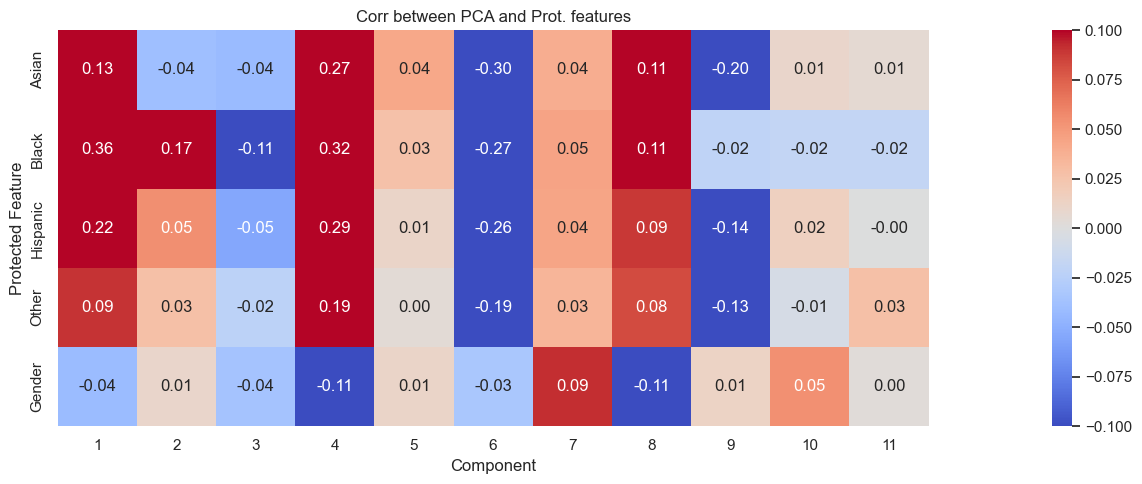

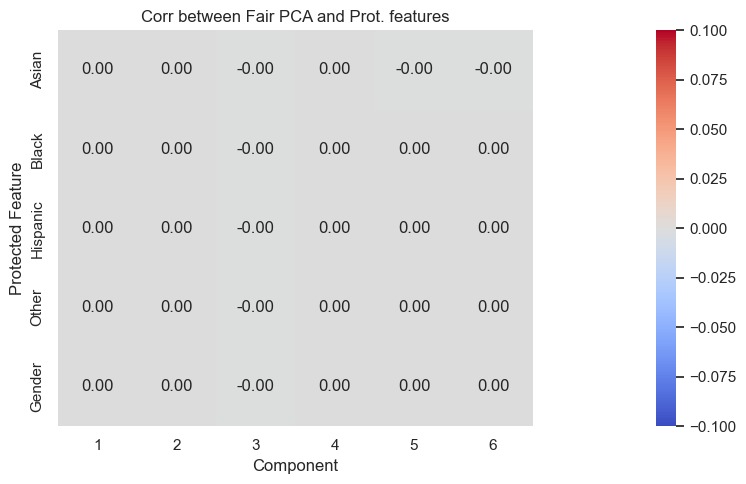

In [299]:
corr_plot(X_train, group_train, fair=False)
corr_plot(X_train, group_train, fair=True)